In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-white')  # 'seaborn-ticks'
# sns.set_style('white')
import dateutil

In [6]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [4]:
with open(r'..\data\metadata\color_schemes.json', 'r') as infile:
    colormaps = json.load(infile)

In [72]:
# Standardize data
# data.loc[:, data_cols] = StandardScaler().fit_transform(data.loc[:, data_cols])
# data.loc[:, data_cols]

# Make file grouping 
hmfg = fg.set_index('combined_col_name')[['animal', 'bg_type']].T
# Make another file grouping
hmfg2 = fg[['animal', 'bg_type', 'gluc_tol']].drop_duplicates().set_index(['bg_type', 'animal'])

d = data.loc[:, data_cols].append(hmfg).T
d = d.groupby(['bg_type', 'animal']).mean()
d = d.join(hmfg2)

# Set metadata as indexes
d.set_index('gluc_tol', append=True, inplace=True)
d.sort_values(['bg_type', 'gluc_tol', 'animal'], ascending=[True, False, True], inplace=True)
# d = d.T
d

l_0        l_1        l_2        l_3  \
bg_type animal gluc_tol                                               
FBG     1091   normal    23.670564  24.426323  23.814945  27.047760   
        1093   normal    23.349007  24.616548  23.379382  26.856975   
        1060   impaired  23.449521  24.831670  23.744392  26.953347   
        1062   impaired  23.216855  24.421992  23.356738  26.891357   
        1074   impaired  23.018708  24.185953  23.780521  27.171006   
        1092   impaired  23.101794  24.529641  23.353036  26.837090   
        1102   impaired  23.397215  24.717923  23.763796  26.669624   
        1076   diabetic  22.679690  23.594023  23.103339  26.243724   
        1082   diabetic  23.431994  24.821577  24.038831  27.055425   
        1101   diabetic  23.154617  24.622188  23.729049  26.855539   
RBG     1091   normal    23.966487  24.912942  23.413989  27.350338   
        1093   normal    23.611918  24.567604  23.952991  26.970232   
        1060   impaired  23.840615  25.054730  24.048209  26.942758   
        1062   impaired  23.174288  23.608273  23.749417  27.198735   
        1074   impaired  23.841427  24.962976  24.020401  27.329256   
        1092   impaired  23.792566  24.777115  23.895966  26.998344   
        1102   impaired  23.327583  23.821103  23.528009  26.981334   
        1076   diabetic  23.734863  24.378175  24.449786  27.084315   
        1082   diabetic  23.484084  24.385322  23.706616  27.033307   
        1101   diabetic  23.527161  24.712632  23.719033  27.351148   

                               l_4        l_5        l_6        l_7  \
bg_type animal gluc_tol                                               
FBG     1091   normal    22.170247  26.436732  30.424704  22.466074   
        1093   normal    22.533255  26.449655  29.886286  22.344402   
        1060   impaired  23.045461  26.772249  30.242452  22.307307   
        1062   impaired  22.580229  26.094048  30.027633  22.107637   
        1074   impaired  22.422509  26.311464  30.149799  22.358722   
        1092   impaired  22.474257  26.422284  29.803868  22.168762   
        1102   impaired  22.677837  26.558844  30.213943  21.652245   
        1076   diabetic  21.424737  25.785970  29.826501  21.363046   
        1082   diabetic  22.366938  26.500553  30.194233  22.469145   
        1101   diabetic  22.692777  26.635056  29.893134  22.022698   
RBG     1091   normal    22.522382  26.369622  30.082804  22.245460   
        1093   normal    22.766641  26.289131  29.724295  22.193878   
        1060   impaired  23.111682  26.549709  30.545997  22.049367   
        1062   impaired  22.836285  25.802277  30.074647  22.321493   
        1074   impaired  23.168719  26.720635  30.201864  22.192797   
        1092   impaired  22.327510  26.536968  30.031506  22.095893   
        1102   impaired  22.490114  26.265088  29.628747  22.088169   
        1076   diabetic  23.238189  26.765223  30.220139  22.219264   
        1082   diabetic  22.766074  26.174567  29.874454  21.999458   
        1101   diabetic  22.704753  26.508672  29.912160  22.483285   

                               l_8        l_9  ...      m_682      m_368  \
bg_type animal gluc_tol                        ...                         
FBG     1091   normal    26.377794  24.326876  ...  20.577814  23.013146   
        1093   normal    25.825897  23.655871  ...  20.256022  22.662139   
        1060   impaired  26.009478  23.951241  ...  20.042547  22.365933   
        1062   impaired  25.893946  23.497447  ...  19.709896  22.319930   
        1074   impaired  26.064572  23.761601  ...  20.633094  22.845992   
        1092   impaired  25.718736  23.434220  ...  20.025014  22.484600   
        1102   impaired  26.003035  23.460890  ...  20.249462  22.592770   
        1076   diabetic  25.680440  22.886061  ...  19.429659  22.204800   
        1082   diabetic  26.126511  23.991184  ...  20.208397  22.441951   
        1101   diabetic  25.784276  23.702454  ...  20.014211  22.569

In [73]:
d.reset_index()

,bg_type,animal,gluc_tol,l_0,l_1,l_2,l_3,l_4,l_5,l_6,...,m_682,m_368,m_340,m_616,m_557,m_169,m_213,m_24,m_505,m_441
0,FBG,1091,normal,23.670564,24.426323,23.814945,27.047760,22.170247,26.436732,30.424704,...,20.577814,23.013146,23.120075,20.738915,21.118374,25.085780,21.197252,27.474643,20.984691,22.255954
1,FBG,1093,normal,23.349007,24.616548,23.379382,26.856975,22.533255,26.449655,29.886286,...,20.256022,22.662139,22.739458,19.997634,20.495530,25.162931,20.732187,27.135962,20.554417,22.162157
2,FBG,1060,impaired,23.449521,24.831670,23.744392,26.953347,23.045461,26.772249,30.242452,...,20.042547,22.365933,22.421491,19.339613,19.695348,24.785966,18.892427,26.632244,19.627304,21.921272
3,FBG,1062,impaired,23.216855,24.421992,23.356738,26.891357,22.580229,26.094048,30.027633,...,19.709896,22.319930,22.357512,19.282644,19.885685,24.788380,19.804368,27.028160,20.056039,22.190772
4,FBG,1074,impaired,23.018708,24.185953,23.780521,27.171006,22.422509,26.311464,30.149799,...,20.633094,22.845992,22.977996,19.999974,20.417869,24.722978,20.766765,27.376654,21.068092,22.268092
5,FBG,1092,impaired,23.101794,24.529641,23.353036,26.837090,22.474257,26.422284,29.803868,...,20.025014,22.484600,22.518859,19.675934,20.337617,24.946609,19.106296,26.760064,19.526662,21.979096
6,FBG,1102,impaired,23.397215,24.717923,23.763796,26.669624,22.677837,26.558844,30.213943,...,20.249462,22.592770,22.726589,19.381277,19.921761,25.045362,20.766016,27.265407,20.951629,22.258362
7,FBG,1076,diabetic,22.679690,23.594023,23.103339,26.243724,21.424737,25.785970,29.826501,...,19.429659,22.204800,22.232570,18.870266,19.335067,24.689008,20.310409,26.922636,19.534830,22.116884
8,FBG,1082,diabetic,23.431994,24.821577,24.038831,27.055425,22.366938,26.500553,30.194233,...,20.208397,22.441951,22.499360,19.556788,19.907344,24.779235,20.455946,27.039009,20.582577,22.050348
9,FBG,1101,diabetic,23.154617,24.622188,23.729049,26.855539,22.692777,26.635056,29.893134,...,20.014211,22.569514,22.574066,19.396910,19.789293,24.982201,19.254855,26.792142,19.237839,21.974182


In [22]:
d.columns.get_level_values('animal')

Int64Index([1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101, 1091,
            1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101],
           dtype='int64', name='animal')

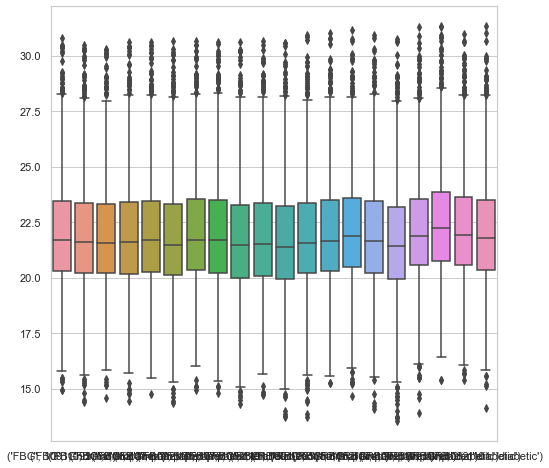

In [55]:
sns.boxplot(data=d)

fig = plt.gcf()
fig.set_size_inches((8,8))

In [57]:
d.filter(regex='1060')

bg_type,FBG,RBG
animal,1060,1060
gluc_tol,impaired,impaired
l_0,23.449521,23.840615
l_1,24.831670,25.054730
l_2,23.744392,24.048209
l_3,26.953347,26.942758
l_4,23.045461,23.111682
...,...,...
m_169,24.785966,24.832177
m_213,18.892427,21.665979


In [71]:
d.T

l_0        l_1        l_2        l_3  \
bg_type animal gluc_tol                                               
FBG     1091   normal    23.670564  24.426323  23.814945  27.047760   
        1093   normal    23.349007  24.616548  23.379382  26.856975   
        1060   impaired  23.449521  24.831670  23.744392  26.953347   
        1062   impaired  23.216855  24.421992  23.356738  26.891357   
        1074   impaired  23.018708  24.185953  23.780521  27.171006   
        1092   impaired  23.101794  24.529641  23.353036  26.837090   
        1102   impaired  23.397215  24.717923  23.763796  26.669624   
        1076   diabetic  22.679690  23.594023  23.103339  26.243724   
        1082   diabetic  23.431994  24.821577  24.038831  27.055425   
        1101   diabetic  23.154617  24.622188  23.729049  26.855539   
RBG     1091   normal    23.966487  24.912942  23.413989  27.350338   
        1093   normal    23.611918  24.567604  23.952991  26.970232   
        1060   impaired  23.840615  25.054730  24.048209  26.942758   
        1062   impaired  23.174288  23.608273  23.749417  27.198735   
        1074   impaired  23.841427  24.962976  24.020401  27.329256   
        1092   impaired  23.792566  24.777115  23.895966  26.998344   
        1102   impaired  23.327583  23.821103  23.528009  26.981334   
        1076   diabetic  23.734863  24.378175  24.449786  27.084315   
        1082   diabetic  23.484084  24.385322  23.706616  27.033307   
        1101   diabetic  23.527161  24.712632  23.719033  27.351148   

                               l_4        l_5        l_6        l_7  \
bg_type animal gluc_tol                                               
FBG     1091   normal    22.170247  26.436732  30.424704  22.466074   
        1093   normal    22.533255  26.449655  29.886286  22.344402   
        1060   impaired  23.045461  26.772249  30.242452  22.307307   
        1062   impaired  22.580229  26.094048  30.027633  22.107637   
        1074   impaired  22.422509  26.311464  30.149799  22.358722   
        1092   impaired  22.474257  26.422284  29.803868  22.168762   
        1102   impaired  22.677837  26.558844  30.213943  21.652245   
        1076   diabetic  21.424737  25.785970  29.826501  21.363046   
        1082   diabetic  22.366938  26.500553  30.194233  22.469145   
        1101   diabetic  22.692777  26.635056  29.893134  22.022698   
RBG     1091   normal    22.522382  26.369622  30.082804  22.245460   
        1093   normal    22.766641  26.289131  29.724295  22.193878   
        1060   impaired  23.111682  26.549709  30.545997  22.049367   
        1062   impaired  22.836285  25.802277  30.074647  22.321493   
        1074   impaired  23.168719  26.720635  30.201864  22.192797   
        1092   impaired  22.327510  26.536968  30.031506  22.095893   
        1102   impaired  22.490114  26.265088  29.628747  22.088169   
        1076   diabetic  23.238189  26.765223  30.220139  22.219264   
        1082   diabetic  22.766074  26.174567  29.874454  21.999458   
        1101   diabetic  22.704753  26.508672  29.912160  22.483285   

                               l_8        l_9  ...      m_682      m_368  \
bg_type animal gluc_tol                        ...                         
FBG     1091   normal    26.377794  24.326876  ...  20.577814  23.013146   
        1093   normal    25.825897  23.655871  ...  20.256022  22.662139   
        1060   impaired  26.009478  23.951241  ...  20.042547  22.365933   
        1062   impaired  25.893946  23.497447  ...  19.709896  22.319930   
        1074   impaired  26.064572  23.761601  ...  20.633094  22.845992   
        1092   impaired  25.718736  23.434220  ...  20.025014  22.484600   
        1102   impaired  26.003035  23.460890  ...  20.249462  22.592770   
        1076   diabetic  25.680440  22.886061  ...  19.429659  22.204800   
        1082   diabetic  26.126511  23.991184  ...  20.208397  22.441951   
        1101   diabetic  25.784276  23.702454  ...  20.014211  22.569

In [82]:
d = d.reset_index()
d

,index,bg_type,animal,gluc_tol,l_0,l_1,l_2,l_3,l_4,l_5,...,m_682,m_368,m_340,m_616,m_557,m_169,m_213,m_24,m_505,m_441
0,0,FBG,1091,normal,23.670564,24.426323,23.814945,27.047760,22.170247,26.436732,...,20.577814,23.013146,23.120075,20.738915,21.118374,25.085780,21.197252,27.474643,20.984691,22.255954
1,1,FBG,1093,normal,23.349007,24.616548,23.379382,26.856975,22.533255,26.449655,...,20.256022,22.662139,22.739458,19.997634,20.495530,25.162931,20.732187,27.135962,20.554417,22.162157
2,2,FBG,1060,impaired,23.449521,24.831670,23.744392,26.953347,23.045461,26.772249,...,20.042547,22.365933,22.421491,19.339613,19.695348,24.785966,18.892427,26.632244,19.627304,21.921272
3,3,FBG,1062,impaired,23.216855,24.421992,23.356738,26.891357,22.580229,26.094048,...,19.709896,22.319930,22.357512,19.282644,19.885685,24.788380,19.804368,27.028160,20.056039,22.190772
4,4,FBG,1074,impaired,23.018708,24.185953,23.780521,27.171006,22.422509,26.311464,...,20.633094,22.845992,22.977996,19.999974,20.417869,24.722978,20.766765,27.376654,21.068092,22.268092
5,5,FBG,1092,impaired,23.101794,24.529641,23.353036,26.837090,22.474257,26.422284,...,20.025014,22.484600,22.518859,19.675934,20.337617,24.946609,19.106296,26.760064,19.526662,21.979096
6,6,FBG,1102,impaired,23.397215,24.717923,23.763796,26.669624,22.677837,26.558844,...,20.249462,22.592770,22.726589,19.381277,19.921761,25.045362,20.766016,27.265407,20.951629,22.258362
7,7,FBG,1076,diabetic,22.679690,23.594023,23.103339,26.243724,21.424737,25.785970,...,19.429659,22.204800,22.232570,18.870266,19.335067,24.689008,20.310409,26.922636,19.534830,22.116884
8,8,FBG,1082,diabetic,23.431994,24.821577,24.038831,27.055425,22.366938,26.500553,...,20.208397,22.441951,22.499360,19.556788,19.907344,24.779235,20.455946,27.039009,20.582577,22.050348
9,9,FBG,1101,diabetic,23.154617,24.622188,23.729049,26.855539,22.692777,26.635056,...,20.014211,22.569514,22.574066,19.396910,19.789293,24.982201,19.254855,26.792142,19.237839,21.974182


<AxesSubplot:>

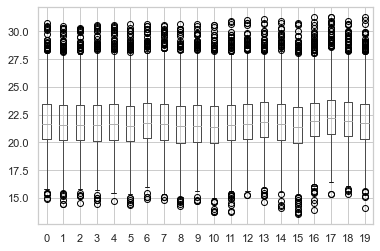

In [91]:
d[metabs_index].T.boxplot()

Index(['l_0', 'l_1', 'l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_7', 'l_8', 'l_9',
       ...
       'm_682', 'm_368', 'm_340', 'm_616', 'm_557', 'm_169', 'm_213', 'm_24',
       'm_505', 'm_441'],
      dtype='object', length=1727)


ValueError: Could not interpret input 'metabs_index'

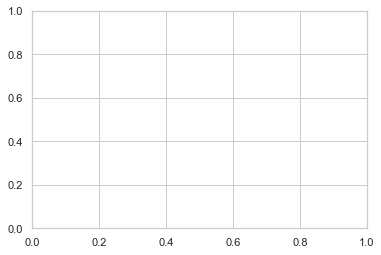

In [88]:
metabs_index = d.filter(regex='m_|l_').columns
print(metabs_index)

fig, ax = plt.subplots()

for i, animal in enumerate(animals_used):
    sns.boxplot(data=d[metabs_index],
                y='metabs_index'
                )
#                 color=colormaps[str(animal)])
                #color='green')  # 
#                 hue=d.columns.get_level_values('animal')
               

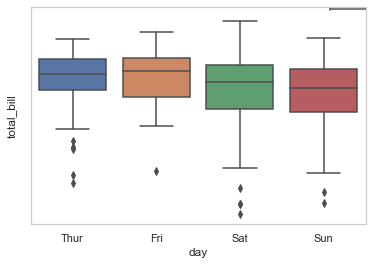

In [53]:
import seaborn as sns

sns.set_theme(style="whitegrid")

tips = sns.load_dataset("tips")

ax = sns.boxplot(x=tips["total_bill"])
ax = sns.boxplot(x="day", y="total_bill", data=tips)

In [49]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
